# Checking if spark session is running
We are lauching a Jupyter notebook using a Spark Session as engine

In [71]:
spark

# Loading and checking data

In [72]:
df = spark.read.load("/home/igor/codes/pd_de/data/datalake/user_categories/2020/01/30")

In [73]:
df.limit(10).toPandas().head()

,studentId_clientType,Register,arquivo,busca,cadastro,carreiras,comentario,configuracoes,disciplina,disciplinas-sugeridas,...,premium,quem-voce-ajudou,ranking,sair,search,srb,tag,topico,video,count_all_access
0,00466c856a6bc2a37a1513b8fbb01dd84d83482c706071...,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,24
1,00cf13aa234a9a8c3ccd5e857e8489d0cace9524722ad9...,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,3
2,00ecb1e3ca763c0b35f85435d9b5a459b410a101fcb9f9...,0,0,3,0,0,0,0,6,0,...,6,0,0,0,0,0,0,0,0,15
3,00f7aff1ec3d2bd48dcb20e4223dd077b812a237c38a11...,0,18,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,21
4,014a52f42a211017c7389a2c967ad2b8ad80be9aa3fba3...,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,12


In [74]:
#columns_to_be_used = ["disciplina", "arquivo", "count_all_access"]
#columns_to_be_used = ["disciplina", "count_all_access"]
columns_to_be_used = ["count_all_access"]
df.columns

['studentId_clientType',
 'Register',
 'arquivo',
 'busca',
 'cadastro',
 'carreiras',
 'comentario',
 'configuracoes',
 'disciplina',
 'disciplinas-sugeridas',
 'download',
 'emailunsubscription',
 'ensino-medio',
 'erro',
 'estudantes-sugeridos',
 'estude',
 'exercicios-resolvidos',
 'explorar-materiais',
 'home',
 'lista',
 'listas',
 'login',
 'marca',
 'materiais-de-estudo',
 'mensagens',
 'meu-premium',
 'novasenha',
 'novidades',
 'pagamento',
 'perfil',
 'perfil-desativado',
 'pergunta',
 'premium',
 'quem-voce-ajudou',
 'ranking',
 'sair',
 'search',
 'srb',
 'tag',
 'topico',
 'video',
 'count_all_access']

# Plotting histogram of data distribution

In [75]:
df.toPandas()[columns_to_be_used].describe()

,count_all_access
count,136613.000000
mean,13.904797
std,26.765272
min,3.000000
25%,3.000000
50%,6.000000
75%,15.000000
max,4986.000000


### Let's remove the outliers from our original dataframe and keep it on hold to a further analysis
We are going to remove the values greater than 2x the standard deviation (std=26.765272)

In [76]:
df_without_outlier = df.where("count_all_access <= 2*26.765272")
#df_without_outlier = df.where("count_all_access <= 2*26.765272 and arquivo<=2*4.529333 and disciplina <= 2*20.033253")
#df_with_outlier = df.where("count_all_access > 2*26.765272")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae21305a58>]],
      dtype=object)

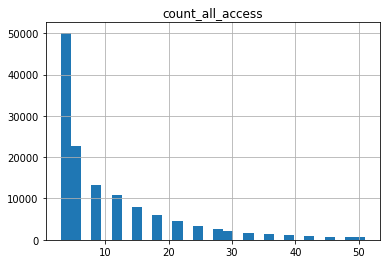

In [77]:
df_without_outlier.toPandas()[["studentId_clientType", "count_all_access"]].hist(bins=30)

There are a lot of users with less than 10 access on the website pages. Let's clusterize these users

# Clusterization
We are going to clusterize our users using a KMeans method from Spark ML. It will divide users in three groups (based on amount of access on website) and then, after clusterization, we will have three user groups: low usage user, moderate usage user, high usage user

In [78]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

columns = columns_to_be_used
vector_a = VectorAssembler(inputCols=columns, outputCol="features")
pipeline = Pipeline(stages=[vector_a])

fitted = pipeline.fit(df_without_outlier)
df_vectorized = fitted.transform(df_without_outlier)

In [79]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(df_vectorized)
predictions = model.transform(df_vectorized)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = "+str(silhouette))

centers = model.clusterCenters()
print("Cluster centers: ")

centers_arr = []
for center in centers:
    print(center)
    centers_arr.append(center)

Silhouette with squared euclidean distance = 0.8145892598592377
Cluster centers: 
[4.71238707]
[37.73312851]
[17.13561602]


In [96]:
#final_df = predictions.select("count_all_access", "prediction")
final_df = predictions.select("studentId_clientType", "count_all_access", "prediction")
final_df.show(10)

+--------------------+----------------+----------+
|studentId_clientType|count_all_access|prediction|
+--------------------+----------------+----------+
|00466c856a6bc2a37...|              24|         2|
|00cf13aa234a9a8c3...|               3|         0|
|00ecb1e3ca763c0b3...|              15|         2|
|00f7aff1ec3d2bd48...|              21|         2|
|014a52f42a211017c...|              12|         2|
|0234cc8e34a82287a...|              18|         2|
|0274f5cdcb328c66c...|               3|         0|
|02b73ddbc191764e5...|               3|         0|
|030d6076776504095...|               3|         0|
|03800610823a57794...|               3|         0|
+--------------------+----------------+----------+
only showing top 10 rows



# Visualizing clustered data
Let's see how much distributed are our users on the access to the website

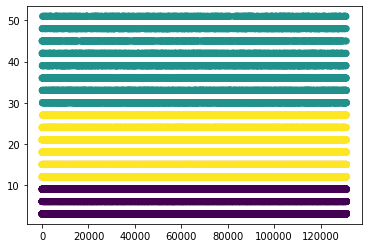

In [81]:
import matplotlib.pyplot as plt

pdf = final_df.toPandas()
#plt.scatter(x=range(len(pdf)), y=pdf["count_all_access"], c = pdf["prediction"])
plt.scatter(x=range(len(pdf)), y=pdf["count_all_access"], c = pdf["prediction"])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae3616b8d0>]],
      dtype=object)

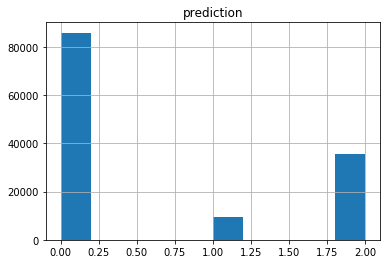

In [82]:
pdf.hist(["prediction"], label=[0, 1, 2])

# Courses analysis
Let's perform some course analysis

In [83]:
def get_data_from_postgresql(database, table, username, password):
    return spark \
        .read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql:" +database) \
        .option("dbtable", "public." + table) \
        .option("user", username) \
        .option("password", password) \
        .load()

In [84]:
#spark.conf.get("spark.driver.extraClassPath")
!ls ../jars

postgresql-42.2.9.jar


In [85]:
courses = get_data_from_postgresql("igoruchoa", "courses", "igoruchoa", "igoruchoa") \
    .withColumnRenamed("Id", "CId")
students = get_data_from_postgresql("igoruchoa", "students", "igoruchoa", "igoruchoa")

In [86]:
students_with_course = students.join(courses, students.CourseId == courses.CId)

In [87]:
courses.where("CId = 1199555").show(20, False)

+-------+-------------------+
|CId    |Name               |
+-------+-------------------+
|1199555|Engenharia Elétrica|
+-------+-------------------+



### Removing source of access from 'final_df'

In [97]:
from pyspark.sql.functions import regexp_replace, col, sum, desc
final_df = final_df.select(regexp_replace("studentId_clientType", '@(.*)','').alias("student_id"), "*") \
    .drop("studentId_clientType")

In [89]:
final_df.show(10, False)

+----------------------------------------------------------------+----------------+----------+
|student_id                                                      |count_all_access|prediction|
+----------------------------------------------------------------+----------------+----------+
|00466c856a6bc2a37a1513b8fbb01dd84d83482c7060719c26ebd0f0e84ec46a|24              |2         |
|00cf13aa234a9a8c3ccd5e857e8489d0cace9524722ad953e82b6b3cae6f392c|3               |0         |
|00ecb1e3ca763c0b35f85435d9b5a459b410a101fcb9f9f8b0517843e9674c1f|15              |2         |
|00f7aff1ec3d2bd48dcb20e4223dd077b812a237c38a116d1b20ea319882a158|21              |2         |
|014a52f42a211017c7389a2c967ad2b8ad80be9aa3fba3e7593018131f4cad07|12              |2         |
|0234cc8e34a82287ac5246729895212e5086cccf7e21c41b9ce40dabad8cfe70|18              |2         |
|0274f5cdcb328c66cef61476bc3e78dc5337b53f48cbf8d884a4039f37f1b7d3|3               |0         |
|02b73ddbc191764e58fa440a2b1b92c4863786e3027a33e52

### Joining dataframes

In [90]:
students_with_course_and_category_level = final_df.join(students_with_course, final_df.student_id == students_with_course.Id)

In [113]:
from pyspark.sql.functions import regexp_replace, col, sum, desc, asc
p_most_popular_courses = students_with_course_and_category_level \
    .groupBy("prediction", "Name") \
    .agg(sum("count_all_access").alias("count")) \
    .filter("prediction = 2") \
    .orderBy(desc("count")) \
    .limit(10) \
    .drop("prediction") \
    .toPandas()

### Top 10 courses of frequent users

In [104]:
p_most_popular_courses.head()

,Name,count
0,Direito,3531
1,Administração,1851
2,Contabilidade / Ciências Contábeis,1329
3,Engenharia Civil,1077
4,Pedagogia,831


### Engagement with website by course

In [120]:
from pyspark.sql.functions import regexp_replace, col, sum, desc, asc
p_engagement_by_course = students_with_course_and_category_level \
    .groupBy("Name") \
    .pivot("prediction") \
    .agg(sum("count_all_access").alias("count")) \
    .withColumnRenamed("0", "Infrequent") \
    .withColumnRenamed("1", "Moderated") \
    .withColumnRenamed("2", "Frequent") \
    .na.fill(0) \
    .orderBy(asc("Name")) \
    .toPandas()

In [121]:
import pandas as pd
pd.set_option('display.max_rows', p_engagement_by_course.shape[0]+1)
p_engagement_by_course

,Name,Infrequent,Moderated,Frequent
0,Administração,840,1197,1851
1,Administração Hospitalar / Gestão Hospitalar,0,108,21
2,Administração Internacional,15,0,12
3,Administração Pública,27,0,45
4,Agroecologia,0,0,30
5,Agronomia,42,72,30
6,Agropecuária,0,0,18
7,Análise e Desenvolvimento de Sistemas,132,93,225
8,Arquitetura,15,0,27
9,Arquitetura e Urbanismo,132,72,141
